<a href="https://colab.research.google.com/github/qorrnsu/2025-1_CV/blob/main/3%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **실험 A: 손실 함수 비교 - CrossEntropyLoss vs MSELoss**

## 실험 목표
- 분류 문제에서 손실 함수의 선택이 학습 성능에 어떤 영향을 주는지 확인한다.
- CrossEntropyLoss와 MSELoss(+softmax)의 수렴 속도, 정확도, 안정성을 비교한다.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 학습 및 테스트 데이터셋 불러오기
def get_data_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))  # 28x28 → 784
    ])
    train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    return DataLoader(train, batch_size=batch_size), DataLoader(test, batch_size=batch_size)

train_loader, _ = get_data_loaders()

activations = {}  # 전역 변수로 저장

def save_activation(name):
    def hook(module, input, output):
        activations[name] = output.detach().cpu()
    return hook

def plot_activations():
    for name, act in activations.items():
        plt.figure(figsize=(6, 3))
        plt.hist(act.view(-1).numpy(), bins=100)
        plt.title(f"Activation Distribution: {name}")
        plt.xlabel("Activation value")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

# 간단한 MLP 모델 정의 (입력 784, 은닉층 256→128, 출력 10 클래스)
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.net(x)


[1] Loss: 494.3464, Accuracy: 0.8120
[2] Loss: 348.1278, Accuracy: 0.8641
[3] Loss: 309.3700, Accuracy: 0.8767
[4] Loss: 284.2752, Accuracy: 0.8861
[5] Loss: 266.1140, Accuracy: 0.8932
[6] Loss: 250.0334, Accuracy: 0.9003
[7] Loss: 235.9178, Accuracy: 0.9061
[8] Loss: 225.7988, Accuracy: 0.9094
[9] Loss: 214.1182, Accuracy: 0.9143
[10] Loss: 203.9085, Accuracy: 0.9169
[11] Loss: 194.5975, Accuracy: 0.9214
[12] Loss: 186.6394, Accuracy: 0.9238
[13] Loss: 179.8889, Accuracy: 0.9261
[14] Loss: 172.2494, Accuracy: 0.9300
[15] Loss: 163.2020, Accuracy: 0.9331
[16] Loss: 158.5068, Accuracy: 0.9349
[17] Loss: 154.1010, Accuracy: 0.9362
[18] Loss: 150.8548, Accuracy: 0.9373
[19] Loss: 143.8672, Accuracy: 0.9406
[20] Loss: 139.0578, Accuracy: 0.9440
[21] Loss: 134.8688, Accuracy: 0.9449
[22] Loss: 129.5005, Accuracy: 0.9459
[23] Loss: 122.7602, Accuracy: 0.9495
[24] Loss: 124.5695, Accuracy: 0.9490
[25] Loss: 119.1119, Accuracy: 0.9515
[26] Loss: 114.6207, Accuracy: 0.9522
[27] Loss: 112.5181, 

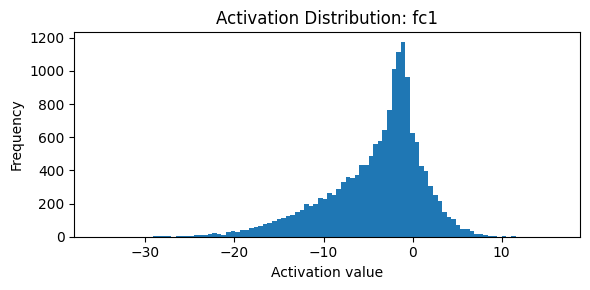

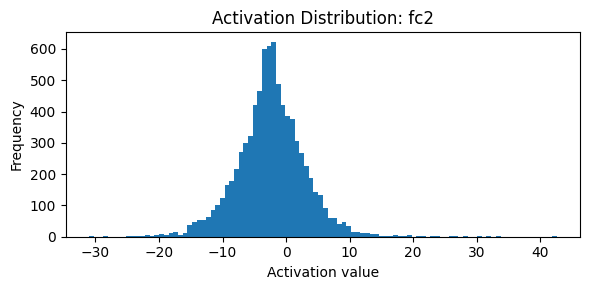

In [7]:
# 학습 함수
def train(model, loss_fn, optimizer, train_loader, use_softmax=False, epochs=30):
    model.train()
    loss_list, acc_list = [], []
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x)

            if use_softmax:
                out = torch.softmax(out, dim=1)
                y_onehot = F.one_hot(y, num_classes=10).float()
                loss = loss_fn(out, y_onehot)
            else:
                loss = loss_fn(out, y)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        acc = correct / total
        loss_list.append(total_loss / total)
        acc_list.append(acc)
        print(f"[{epoch+1}] Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")
    return loss_list, acc_list

# 실험 1: CrossEntropy
model_ce = MLP()

# hook 등록 (fc1: Linear(784→256), fc2: Linear(256→128))
model_ce.net[0].register_forward_hook(save_activation("fc1"))  # 첫 번째 은닉층
model_ce.net[2].register_forward_hook(save_activation("fc2"))  # 두 번째 은닉층

optimizer_ce = torch.optim.Adam(model_ce.parameters(), lr=0.001)
loss_fn_ce = nn.CrossEntropyLoss()
loss_ce, acc_ce = train(model_ce, loss_fn_ce, optimizer_ce, train_loader)

# 실험 2: MSE + softmax
model_mse = MLP()
optimizer_mse = torch.optim.Adam(model_mse.parameters(), lr=0.001)
loss_fn_mse = nn.MSELoss()
loss_mse, acc_mse = train(model_mse, loss_fn_mse, optimizer_mse, train_loader, use_softmax=True)

model_ce.eval()
with torch.no_grad():
    for x, _ in train_loader:
        _ = model_ce(x)
        break

plot_activations()

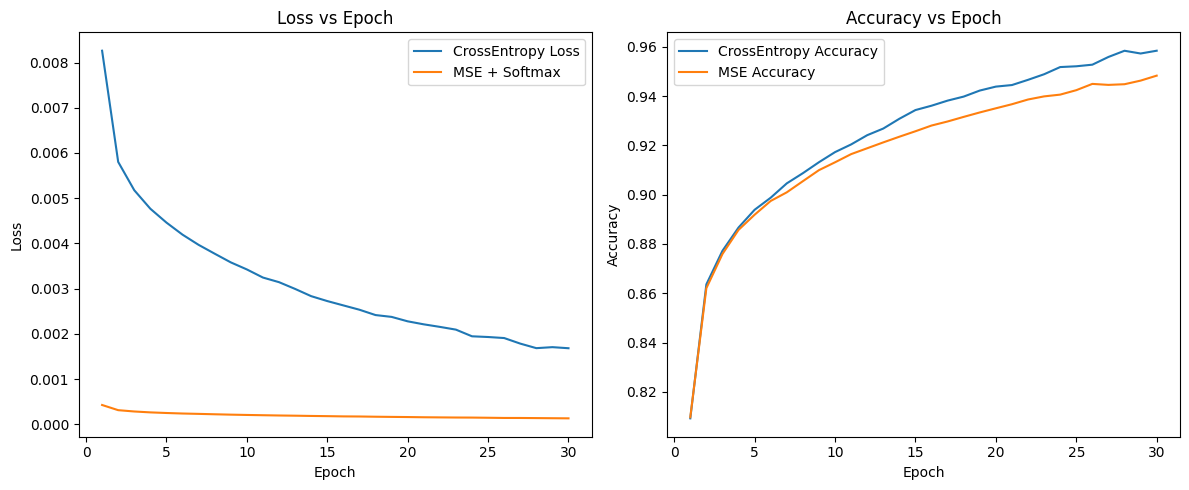

In [ ]:
# 그래프
epochs = list(range(1, len(loss_ce) + 1))
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_ce, label="CrossEntropy Loss")
plt.plot(epochs, loss_mse, label="MSE + Softmax")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_ce, label="CrossEntropy Accuracy")
plt.plot(epochs, acc_mse, label="MSE Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()

plt.tight_layout()
plt.show()


# **실험 B: 활성화 함수 비교 (ReLU vs LeakyReLU vs Sigmoid)**

## 실험 목표
- ReLU에서 발생하는 Dead Neuron 문제 확인
- LeakyReLU의 완화 효과 분석
- Sigmoid에서의 Gradient Vanishing 현상 확인


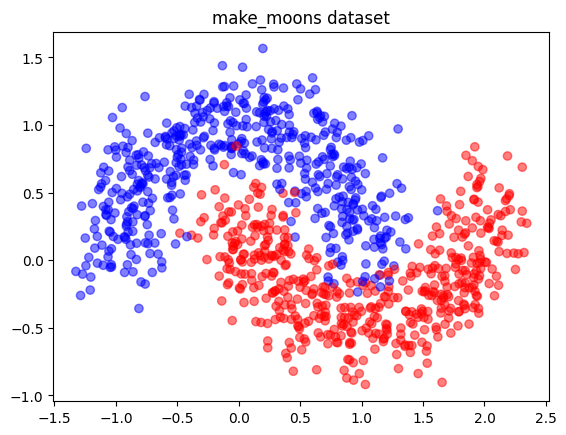

In [16]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# 데이터 생성
X, y = make_moons(n_samples=1000, noise=0.2)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(test_X, test_y), batch_size=64)


# 데이터 시각화
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.5)
plt.title("make_moons dataset")
plt.show()

activations = {}
def save_activation(name):
    def hook(module, input, output):
        activations[name] = output.detach().cpu()
    return hook

def measure_dead_neurons(activation_tensor):
    dead_neurons = (activation_tensor == 0).all(dim=0).sum().item()
    total_neurons = activation_tensor.shape[1]
    return dead_neurons / total_neurons * 100

def average_dead_ratio(model, loader, max_batches=5):
    dead_counts = {"fc1": 0, "fc2": 0}
    total_counts = {"fc1": 0, "fc2": 0}
    with torch.no_grad():
        for i, (x, _) in enumerate(loader):
            if i >= max_batches:
                break
            _ = model(x)
            for layer in ["fc1", "fc2"]:
                dead = (activations[layer] == 0).all(dim=0).sum().item()
                total = activations[layer].shape[1]
                dead_counts[layer] += dead
                total_counts[layer] += total
    return {layer: (dead_counts[layer] / total_counts[layer]) * 100 for layer in dead_counts}

In [17]:
# 모델 정의
class MLP_B(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.act1 = activation
        self.fc2 = nn.Linear(16, 16)
        self.act2 = activation
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        return self.fc3(x)

model_relu = MLP_B(nn.ReLU())
model_relu.fc1.register_forward_hook(save_activation("fc1"))
model_relu.fc2.register_forward_hook(save_activation("fc2"))


# 학습 함수
def train(model, loader, optimizer, loss_fn, epochs=200):
    loss_hist, acc_hist = [], []
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for x, y in loader:
            optimizer.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        acc = correct / total
        loss_hist.append(total_loss / total)
        acc_hist.append(acc)
        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Loss={total_loss:.4f}, Acc={acc:.4f}")
    return loss_hist, acc_hist

# 평가 함수 정의
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            out = model(x)
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    acc = correct / total
    print(f"테스트 정확도: {acc:.4f}")
    return acc

{'fc1': 0.0, 'fc2': 0.0}



ReLU 실험 시작
Epoch 0: Loss=8.2349, Acc=0.6000
Epoch 20: Loss=0.8426, Acc=0.9688
Epoch 40: Loss=0.8146, Acc=0.9712
Epoch 60: Loss=0.8744, Acc=0.9688
Epoch 80: Loss=0.7426, Acc=0.9725
Epoch 100: Loss=0.8214, Acc=0.9762
Epoch 120: Loss=0.8096, Acc=0.9712
Epoch 140: Loss=0.8657, Acc=0.9712
Epoch 160: Loss=0.7545, Acc=0.9762
Epoch 180: Loss=0.7042, Acc=0.9738

LeakyReLU 실험 시작
Epoch 0: Loss=7.7626, Acc=0.6937
Epoch 20: Loss=0.8586, Acc=0.9738
Epoch 40: Loss=0.8205, Acc=0.9725
Epoch 60: Loss=0.8517, Acc=0.9725
Epoch 80: Loss=0.7517, Acc=0.9712
Epoch 100: Loss=0.8156, Acc=0.9738
Epoch 120: Loss=0.7155, Acc=0.9750
Epoch 140: Loss=0.7938, Acc=0.9725
Epoch 160: Loss=0.7698, Acc=0.9725
Epoch 180: Loss=0.6829, Acc=0.9738

Sigmoid 실험 시작
Epoch 0: Loss=9.0564, Acc=0.5000
Epoch 20: Loss=3.9584, Acc=0.8650
Epoch 40: Loss=3.1396, Acc=0.8888
Epoch 60: Loss=1.3412, Acc=0.9613
Epoch 80: Loss=0.9773, Acc=0.9712
Epoch 100: Loss=0.9255, Acc=0.9725
Epoch 120: Loss=0.8865, Acc=0.9738
Epoch 140: Loss=0.8554, Acc=0

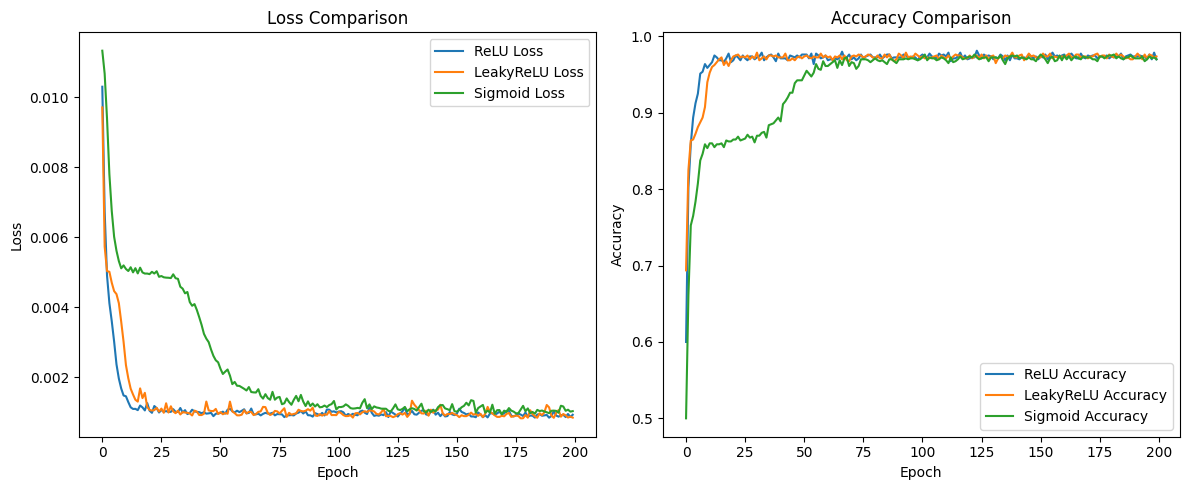

{'fc1': 0.0, 'fc2': 0.0}


In [21]:
activations = {
    'ReLU': nn.ReLU(),
    'LeakyReLU': nn.LeakyReLU(0.01),
    'Sigmoid': nn.Sigmoid()
}

results = {}
models = {}

for name, act_fn in activations.items():
    print(f"\n{name} 실험 시작")
    model = MLP_B(activation=act_fn)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()
    loss_hist, acc_hist = train(model, train_loader, optimizer, loss_fn)
    results[name] = (loss_hist, acc_hist)
    models[name] = model

# 결과 시각화
epochs = list(range(len(list(results.values())[0][0])))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for name in results:
    plt.plot(epochs, results[name][0], label=f"{name} Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Comparison")
plt.legend()

plt.subplot(1, 2, 2)
for name in results:
    plt.plot(epochs, results[name][1], label=f"{name} Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Comparison")
plt.legend()
plt.tight_layout()
plt.show()

model_relu.eval()
dead_ratios = average_dead_ratio(model_relu, train_loader)
print(dead_ratios)

# **실험 C: 최적화 알고리즘 비교 (SGD vs Momentum vs Adam)**

## 실험 목표
- 서로 다른 Optimizer가 학습 곡선에 어떤 영향을 미치는지 비교
- 수렴 속도, Loss 감소 패턴, 정확도 안정성 등을 분석


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 데이터 로딩
def get_loader(batch_size=64):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
    train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    return DataLoader(train, batch_size=batch_size), DataLoader(test, batch_size=batch_size)

train_loader, _ = get_loader()

# MLP 모델
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.net(x)


In [ ]:
# 학습 함수
def train(model, loss_fn, optimizer, train_loader, scheduler=None, epochs=30):
    model.train()
    loss_list, acc_list = [], []
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        if scheduler:
            scheduler.step()

        acc = correct / total
        loss_list.append(total_loss / total)
        acc_list.append(acc)
        print(f"[{epoch+1}] Loss={total_loss:.4f}, Acc={acc:.4f}")
    return loss_list, acc_list

# 실험 조건
optimizers = {
    "SGD": lambda p: torch.optim.SGD(p, lr=0.1),
    "SGD+Momentum": lambda p: torch.optim.SGD(p, lr=0.05, momentum=0.9),
    "Adam": lambda p: torch.optim.Adam(p, lr=0.001)
}

results = {}

for name, opt_fn in optimizers.items():
    print(f"\nOptimizer: {name}")
    model = MLP()
    optimizer = opt_fn(model.parameters())
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    loss_fn = nn.CrossEntropyLoss()
    loss_hist, acc_hist = train(model, loss_fn, optimizer, train_loader, scheduler=scheduler)
    results[name] = (loss_hist, acc_hist)

# 실험 결과 정의
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            output = model(x)
            pred = output.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    acc = correct / total
    print(f"테스트 정확도: {acc:.4f}")


Optimizer: SGD
[1] Loss=637.1366, Acc=0.7567
[2] Loss=403.2185, Acc=0.8456
[3] Loss=356.1144, Acc=0.8615
[4] Loss=327.9691, Acc=0.8716
[5] Loss=307.6950, Acc=0.8787
[6] Loss=291.5873, Acc=0.8851
[7] Loss=278.6412, Acc=0.8906
[8] Loss=267.5186, Acc=0.8947
[9] Loss=257.8759, Acc=0.8985
[10] Loss=249.3802, Acc=0.9014
[11] Loss=241.9134, Acc=0.9050
[12] Loss=235.1965, Acc=0.9076
[13] Loss=229.2150, Acc=0.9101
[14] Loss=223.8635, Acc=0.9122
[15] Loss=219.0768, Acc=0.9141
[16] Loss=214.7042, Acc=0.9159
[17] Loss=210.6745, Acc=0.9177
[18] Loss=207.1478, Acc=0.9192
[19] Loss=203.8540, Acc=0.9205
[20] Loss=200.8909, Acc=0.9218
[21] Loss=198.1954, Acc=0.9228
[22] Loss=195.7751, Acc=0.9237
[23] Loss=193.5979, Acc=0.9248
[24] Loss=191.5128, Acc=0.9257
[25] Loss=189.6897, Acc=0.9267
[26] Loss=188.0191, Acc=0.9278
[27] Loss=186.5180, Acc=0.9282
[28] Loss=185.1297, Acc=0.9290
[29] Loss=183.8797, Acc=0.9294
[30] Loss=182.7903, Acc=0.9299

Optimizer: SGD+Momentum
[1] Loss=526.0037, Acc=0.7950
[2] Loss

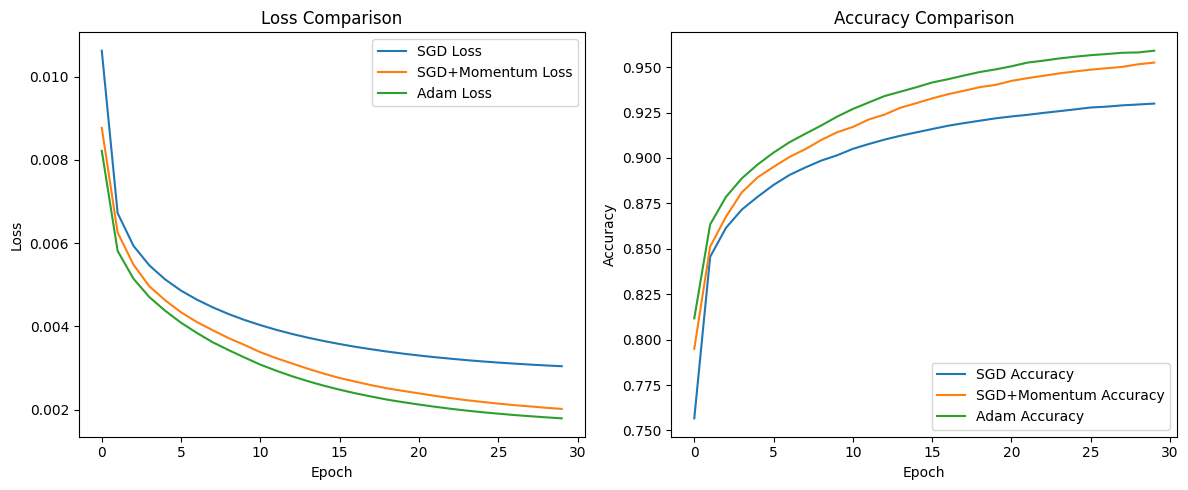

In [ ]:
epochs = list(range(len(list(results.values())[0][0])))

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
for name in results:
    plt.plot(epochs, results[name][0], label=f"{name} Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Comparison")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
for name in results:
    plt.plot(epochs, results[name][1], label=f"{name} Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Comparison")
plt.legend()

plt.tight_layout()
plt.show()